# **Проект исследования поведения пользователей приложения Procrastinate Pro+**

## **План исследования с оглавлением**

Работать с данными будем в следующем порядке:
 - [данные о датасете](#данные)
 - [подготовка данных](#предобработка)
 - [задание функций](#функции)
 - [исследовательский анализ данных, графики, локальные выводы](#ИАД)
 - [оценка маркетинга](#маркетинг)
 - [оценка окупаемости рекламы](#гипотезы)
 - [общий вывод исследования](#выводы)

**Общая информация о задаче**

Компания запустила приложение, купила его рекламу, но терпит убытки. В рамках проекта предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### **Данные о датасете** <a id = 'данные'></a> 

В нашем распоряжении три датасета. Файл 
- visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
- orders_info_short.csv — информацию о покупках, а 
- costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv
- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.

## **Подготовка данных**  <a id = 'предобработка'></a> 

In [1]:
# импортируем библиотеки, которые могут нам понадобиться в исследовании
import pandas as pd   # для работы с дата фреймами
import numpy as np    # для выполнения расчетов
from datetime import datetime, timedelta   # для работы с форматом даты и времени
from matplotlib import pyplot as plt       # для работы с графиками

In [2]:
# загрузим данные либо с локального диска, либо с сервера Яндекса
try:
    visits, orders, commercial = (pd.read_csv(r'C:\Users\rosto\OneDrive\Документы\Learning_is_the_light\Projects_and_data\Procrastinate Pro+\visits_info_short.csv'),
                                  pd.read_csv(r'C:\Users\rosto\OneDrive\Документы\Learning_is_the_light\Projects_and_data\Procrastinate Pro+\orders_info_short.csv'),
                                  pd.read_csv(r'C:\Users\rosto\OneDrive\Документы\Learning_is_the_light\Projects_and_data\Procrastinate Pro+\costs_info_short.csv'))
except:
    visits, orders, commercial = (pd.read_csv('/datasets/visits_info_short.csv'),
                                  pd.read_csv('/datasets/orders_info_short.csv'),
                                  pd.read_csv('/datasets/costs_info_short.csv')) 
else:
    print ('Файлы скопированы')


Посмотрим на каждый из датасетов

In [3]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


В данных о посещении сайта видим следующее:
- во всех столбцах одинаковое количество данных, значит пропусков нет
- названия столбцов не приведены к нижнему регистру и имеют пробелы в названиях - необходимо привести к нижнему регистру и убрать пробелы
- данные в столбцах начала и окончания сессии имеют форма object - необходимо привести к формату даты

In [4]:
# приведем названия столбцов  к прописным буквам
visits.columns = visits.columns.str.lower()
#  заменим в названиях пробел на нижнее подчеркивание
visits.columns = visits.columns.str.replace(' ', '_')

# столбцы сессий приведем к формату даты
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# проверим датасет на наличие дубликатов
visits.duplicated().sum()


0

Дупликатов не обнаружено, столбцы переименованы и приведены к нужному типу. 

Посмотрим на датасет с информацией о покупках

In [5]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Здесь также видна необходимость менять названия столбцов и приводить столбец даты события к формату даты

In [6]:
# приведем названия столбцов  к прописным буквам
orders.columns = orders.columns.str.lower()
#  заменим в названиях пробел на нижнее подчеркивание
orders.columns = orders.columns.str.replace(' ', '_')

# столбцы сессий приведем к формату даты
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

# проверим датасет на наличие дубликатов
orders.duplicated().sum()


0

In [7]:
commercial.info()
commercial.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [8]:
# приведем названия столбцов  к прописным буквам
commercial.columns = commercial.columns.str.lower()

# столбцы сессий приведем к формату даты
commercial['dt'] = pd.to_datetime(commercial['dt'])

# проверим датасет на наличие дубликатов
commercial.duplicated().sum()



0

## **Задание необходимый функций** <a id = 'функции'></a> 

В проекте используем написанные ранее функции

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]): # передаем в функцию данные о сессиях, заказах, 
                                                                      # событиях?,  расходах на рекламу

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])    # сортируем по id пользователя и началу сессии
        .groupby('user_id')                                      # группируем по пользователю
        .agg(
            {
                'session_start': 'first',                        # в таблицу включаем дату первой сессии
                'channel': 'first',                              # первый канал
                'device': 'first',                               # первое устройство
                'region': 'first',                               # и регион входа
            }
        )
        .rename(columns={'session_start': 'first_ts'})          # переименовываем колонку  
        .reset_index()                                          # сбрасываем индексы
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:                                     # для каждого события в списке событий  
        if event in events['event_name'].unique():                # если событие есть в файле событий и
            profiles[event] = profiles['user_id'].isin(           # то в столбец этого события поставить TRUE
                events.query('event_name == @event')['user_id'].unique() # напротив пользователя
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])                      # группируем файл профилей по дате и каналу привлечения
        .agg({'user_id': 'nunique'})                             # в ячейках таблицы считаем уникальных пользователей
        .rename(columns={'user_id': 'unique_users'})             # переименовываем колонку
        .reset_index()                                    
    )

    new_users['dt'] = pd.to_datetime(new_users['dt'])
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')  # добавляем к расходам на рекламу число новых польз
                                                                         # по дате и каналу привлечения

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    profiles['dt'] = pd.to_datetime(profiles['dt'])

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [10]:
# функция для расчёта удержания

def get_retention(                          
    profiles,                               # передаем функции данные о профилях
    sessions,                               # о сессиях
    observation_date,                       # дату наблюдения
    horizon_days,                           # горизонт анализа
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date                      # считаем крайнюю дату возможных наблюдений
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')   # исключаем профили тех, кто не попал в гор анализа  

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(                                         # прикрепляем к пользователям инфу о сессиях
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (                                             # считаем лайфтайм пользователей для каждой сессии
        result_raw['session_start'] - result_raw['first_ts']               # вычитая из даты начала сессии время первой
    ).dt.days

    # функция для группировки таблицы по желаемым признакам   
    def group_by_dimensions(df, dims, horizon_days):                       # группируем дф по желаемым признакам
        result = df.pivot_table(                                           # делая сводную таблицу по этому признаку
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (                                                   # считаем размеры когорт
            df.groupby(dims)                                               # также группируя по этому признаку
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0) # прикрепляем к результату размеры когорт
        result = result.div(result['cohort_size'], axis=0)                 # делим все на размеры когорт
        result = result[['cohort_size'] + list(range(horizon_days))]       # добавляем к размерам когорт лист кол-ва горизонта
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## **Исследовательский анализ даных** <a id = 'ИАД'></a> 

In [17]:
# с использованием функции получим данные о профилях пользователей
# передав функции данные о сессиях, заказах и расходах на рекламу
event = []
profiles = get_profiles(visits, orders, event, commercial)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
# определим минимальную и максимальные даты привлечения пользователей
print(' Минимальная дата привлечения пользователя:', profiles['first_ts'].min())
print(' Максимальная дата привлечения пользователя:', profiles['first_ts'].max())


 Минимальная дата привлечения пользователя: 2019-05-01 00:00:41
 Максимальная дата привлечения пользователя: 2019-10-27 23:59:04


Выясним, из каких стран пользователи приходят в приложение, и в какой стране больше всего платящих пользователей.

In [19]:
# для этого сгруппируем пользователей по стране, посчитав общее количество пользователей и количество тех, кто платит
country_data = profiles.groupby('region').agg({'user_id' :'count', 'payer': 'sum'}).reset_index()
country_data['share_payer'] = round((country_data['payer']/country_data['user_id']*100), 2)
country_data.sort_values(by = 'share_payer', ascending = False)

,region,user_id,payer,share_payer
3,United States,100002,6902,6.90
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
0,France,17450,663,3.80


Больше всего платящих пользователей как в абсолютном количестве, так и в доле относительно общеги их числа приходится на США, с достаточно большим отрывом.

Посчитаем аналогичный показатель по усройству.

In [20]:
device_data = profiles.groupby('device').agg({'user_id' :'count', 'payer': 'sum'}).reset_index()
device_data['share_payer'] = round((device_data['payer']/device_data['user_id']*100), 2)
device_data.sort_values(by = 'share_payer', ascending = False)

,device,user_id,payer,share_payer
1,Mac,30042,1912,6.36
3,iPhone,54479,3382,6.21
0,Android,35032,2050,5.85
2,PC,30455,1537,5.05


Наиболее часто из общего числа пользователей платят клиенты, использующие технику Apple, реже всех делают платежи пользователи PC.

И посчитаем источники привлечения.

In [21]:
def share_payer (profiles_data, by):
    need_data = profiles_data.groupby(by).agg({'user_id' :'count', 'payer': 'sum'}).reset_index()
    need_data['share_payer'] = round((need_data['payer']/need_data['user_id']*100), 2)
    return need_data.sort_values(by = 'share_payer', ascending = False)

In [22]:
share_payer(profiles, 'channel')

,channel,user_id,payer,share_payer
1,FaceBoom,29144,3557,12.20
0,AdNonSense,3880,440,11.34
9,lambdaMediaAds,2149,225,10.47
6,TipTop,19561,1878,9.60
5,RocketSuperAds,4448,352,7.91
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
3,MediaTornado,4364,156,3.57
2,LeapBob,8553,262,3.06
4,OppleCreativeMedia,8605,233,2.71


Среди каналов привлечения самые платящие пользователи приходят из FaceBoom, как по доле так и по общему количеству плательщиков. Самая низкая доля плательщиков у органического трафика.

**Промежуточные выводы**

Самые платящие пользователи живут в США, пользуются техникой Эппл и привлечены через FaceBoom. Реже всего платят пользователи из Фрнации, те, кто используют персональный компьютер, а также те, кто пришел на сайт самостоятельно. Наиболее интересно для дальнейшего исследования выглядят данные по каналам привлечения, так как среди них наблюдаются значительные различия в доле пользователей, которые пользуются платными услугами приложения.

## **Оценка маркетинга** <a id = 'маркетинг'></a> 

Посчитаем общую сумму расходов на маркетинг, посмотрим как траты распределены по источникам, и покажем изменения этих трат во времени.



In [23]:
# выведем общую сумму трат на маркетинг
print('Общие затраты на маркетинг составили', round(commercial['costs'].sum()), 'условных единиц')
# проверим эту сумму с файлом профилей пользователей
print('Сумма затрат из файла пользователей', round(profiles['acquisition_cost'].sum()))

Общие затраты на маркетинг составили 105497 условных единиц
Сумма затрат из файла пользователей 105497


In [24]:
# посмотрим на распределение этих затрат между каналами
# для этого сгруппируем траты по каналу
commercial.groupby('channel')['costs'].sum().reset_index().sort_values(by = 'costs', ascending = False)


,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


In [25]:
# для оценки изменения трат по каналам с течением времени добавим столбец месяца
commercial['month'] = pd.DatetimeIndex(commercial['dt']).month 
# и сделаем сводную таблицу по месяцам и каналам
channeles = commercial.pivot_table(index = ['month'], columns = 'channel',  values = 'costs', aggfunc = 'sum' ).reset_index()


<function matplotlib.pyplot.show(close=None, block=None)>

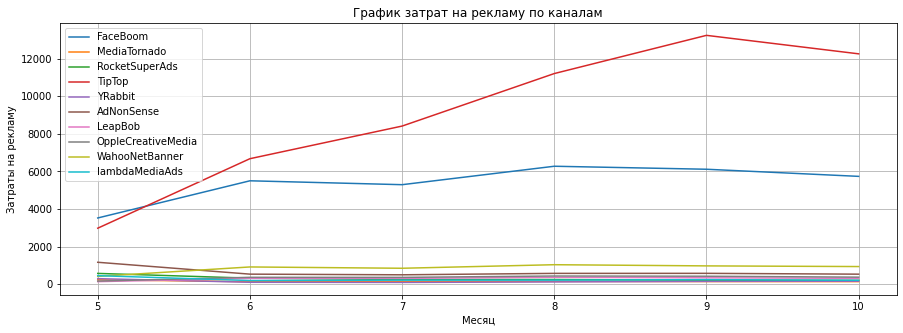

In [26]:
# визуализируем расходы по каналам и месяцам
# зададим размер  графика
plt.figure(figsize=(15, 5))
# для построения графиков осью Х выберем месяцы
x = channeles['month']

# в качестве Y нам нужны продажи по каналам
# так как платформ несколько, напишем цикл перебора каналов
for y in commercial['channel'].unique():
    plt.plot(x, channeles[y], label = y)
    
plt.title('График затрат на рекламу по каналам')  # подпись графика
plt.xlabel('Месяц')  # ось Х
plt.ylabel('Затраты на рекламу')   # ось Y
plt.legend()  # вывод подписей линий графика
plt.grid()  # выведем решетку

plt.show    


По таблице и по графику расходов на рекламу видно, что наибольшие инвестиции были направлены в канал TipTop, и они росли от месяца к месяцу. Второй по размеру инвестиций канал - FaceBoom. Расходы на него почти в два раза меньше, чем на TipTop, и практически постоянны с течением времени. Расходы на отсальные каналы привлечения существенно меньше, чем на двух лидеров. 

Посчитаем, сколько в среднем стоило привлечение одного пользователя из одного источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [27]:
# для этого из файла профилей сгруппируем пользователей по источникам привлечения и подсчетом средних затрат на пользователя
cac_channel = (profiles.groupby('channel')['acquisition_cost'].mean().reset_index()
                                .sort_values(by = 'acquisition_cost', ascending = False))
cac_channel

,channel,acquisition_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


In [28]:
# посчитаем среднюю стоимость привлечения одгого клиента для всего проекта
print('Средняя стоимость привлечения одного клиента, в том числе organic', round(profiles['acquisition_cost'].mean(),2), 'у.е.')
print('Средняя стоимость привлечения одного клиента, без organic', 
      round(profiles.query('channel != "organic"')['acquisition_cost'].mean(),2), 'у.е.')


Средняя стоимость привлечения одного клиента, в том числе organic 0.7 у.е.
Средняя стоимость привлечения одного клиента, без organic 1.13 у.е.


**Промежуточные выводы**

По результатам анализа стоимости привлечения клиентов по разным каналам видно, что наибольшая стоимость как общая, так и в среднем на одного клиента, без учета того, стали они плательщиками или нет, у каналов TipTop и FaceBoom. Причем стоимость одного клиента в TipTop более чем в два раза выше, чем у FaceBoom. При этом мы помним, что клиенты, привлеченные через TipTop только на четвертом месте среди всех каналов по доле тех, кто совершает платеж.

В следующем блоке исследования посмотрим на окупаемость рекламы по каждому из каналов.

## **Оценка окупаемости рекламы** <a id = 'гипотезы'></a> 

Проанализируем окупаемость рекламы. Мы находимся в дате 1-е ноября 2019 года, в бизнес-плане заложено, что пользователи должны окупаться не позднее двух недель, после привлечения. 

На этом этапе примем решение о оставлении в рассматриваемых данных информации об органических пользователях. Хоть мы и не  тратим деньги на их привлечение в явном виде, мы делаем это через развитие сайта, увеличение популярности приложения, поэтому считаю что надо посмотреть на динамику показателей по этим пользователям также.

In [29]:
# зададим день, в котором мы находимся 
observation_date = datetime(2019, 11, 1).date() 
# и горизонт анализа, время в течении которого привлечение пользователей должно окупаться
horizon_days = 14  

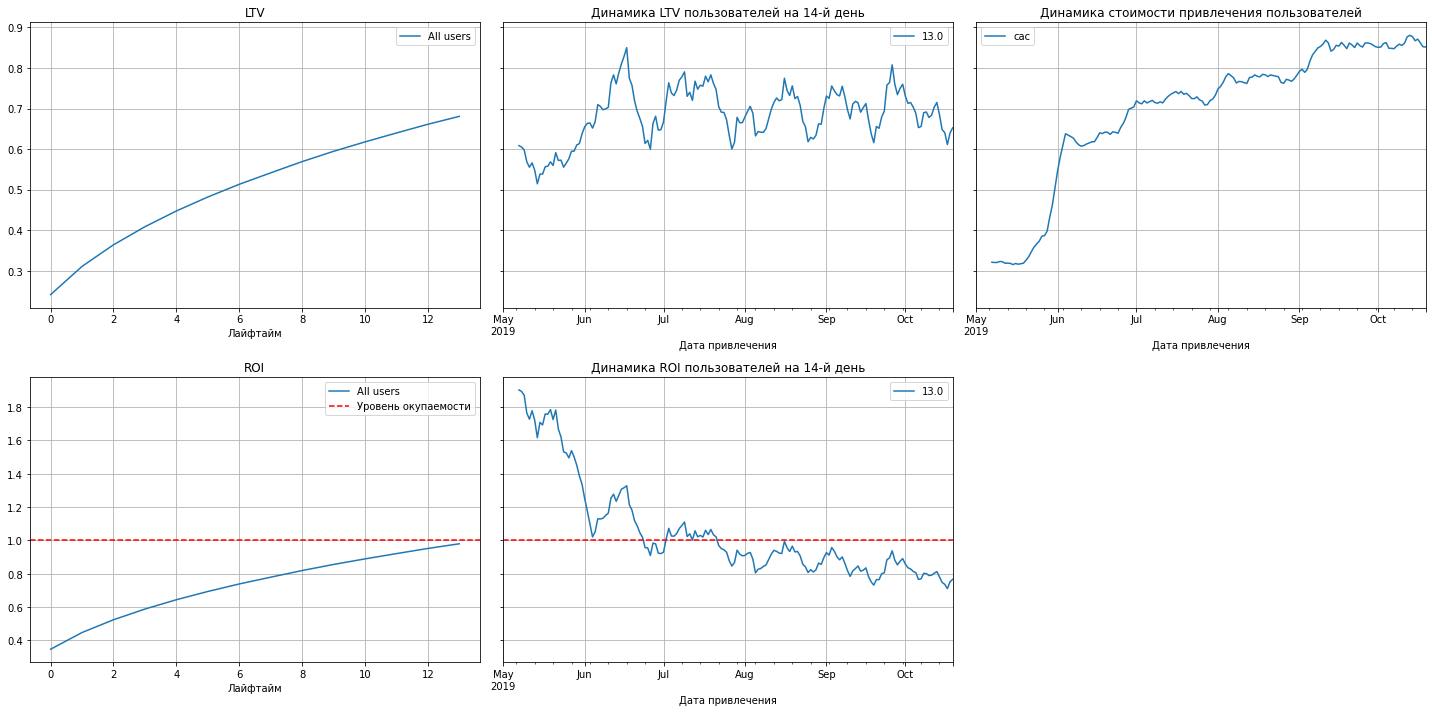

In [30]:
# передаем функции get_ltv данные по профилям, заказам, дату наблюдений, горизонт
# на выходе получаем данные по LTV, ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days,
                                                                       dimensions=[], ignore_horizon=False)

# и с помощью функции визуализации этих показателей посмотрим на них в графиках
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Выводы по общей окупаемости рекламы**

- За рассматриваемый период реклама не окупается, ROI не достигает 100% на 14-й день пользования приложением, как заложено в бизнес-плане.
- стоимость привлечения пользователя резко выросла в июне 2019 года, потом постепенно росла до сентября и с тех пор находится примерно на одном уровне. В анализе маркетинга, мы видели что в эти же периоды значительно выросли общие траты на канал привлечения TipTop
- ROI пользователей имеет обратную кривую, до середины июня этот показатель выше 100%, потом около месяца колеблется около 100% и с тех пор и до настоящего времени находится ниже 100%

Из этих данных можно сделать промежуточный вывод, что увеличение трат на привлечение пользователей, которое произошло начиная с июня не увеличило среднюю ценность одного клиента, из-за чего эти затраты не окупаются.

Для выяснения причин этого рассмотрим эти показатели в разрезе каналов привлечения и стран.

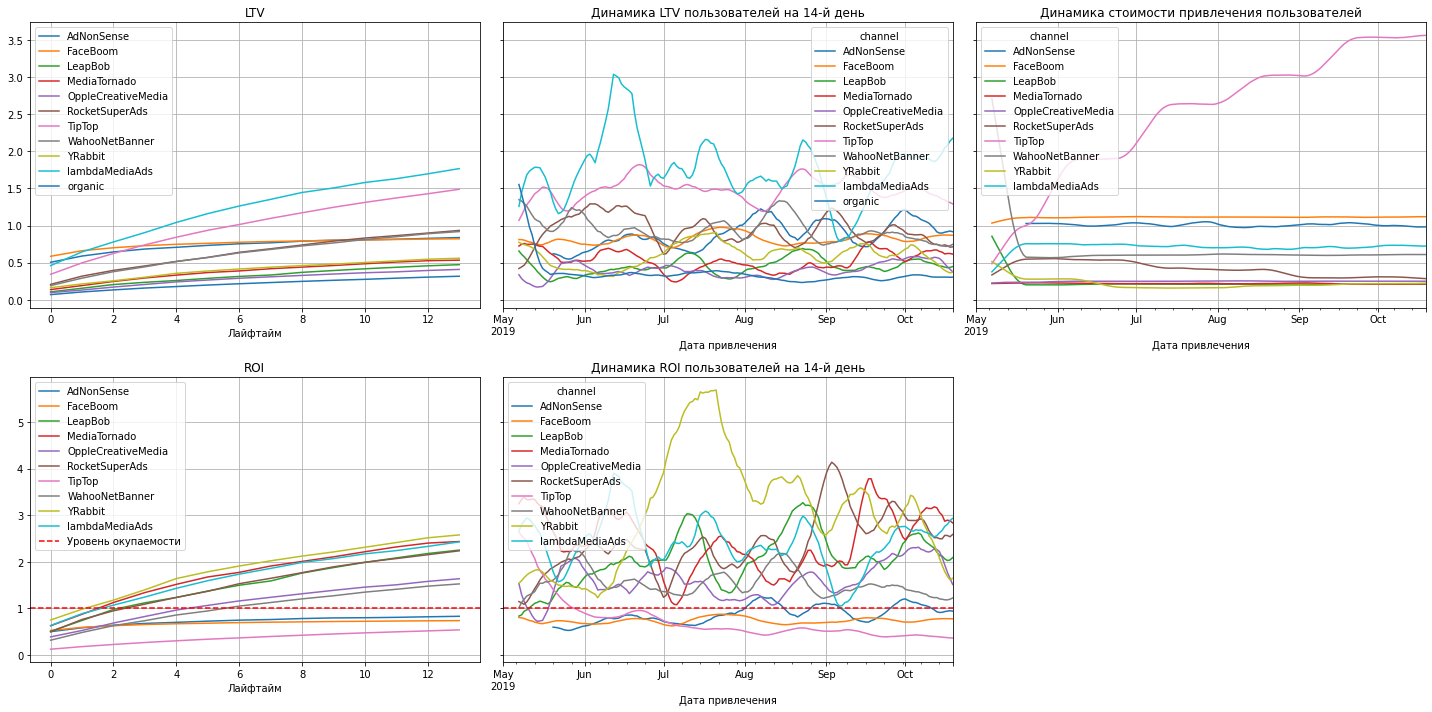

In [31]:
# вызовем функцию расчета и визуализации, с рассмотрением в разрезе каналов привлечения
# передаем функции get_ltv данные по профилям, заказам, дату наблюдений, горизонт
# на выходе получаем данные по LTV, ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days,
                                                                       dimensions=['channel'], ignore_horizon=False)
# для данных о динамике LTV и ROI применим функцию сглаживания с периодом 17 дней
ltv_history = filter_data(ltv_history, 14)
roi_history = filter_data(roi_history, 14)

# и с помощью функции визуализации этих показателей посмотрим на них в графиках
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Выводы по графикам по каналам привлечения**

- три канала привлечения убыточны, то есть ROI не достигает 100% на 14-й день после привлечения пользьвателя, это TipTop, FaceBoom, AdNonSense
- остальные каналы окупаются на 2-6 день с момента привлечения пользователя
- самая высокая окупаемость у YRabbit
- в динамике ROI видна сезонность у некоторых каналов, возможно стоит это учитывать при планировании расходов в будущем.
- расходы на привлечение в большинстве каналов стабильны, за исключением расходов на TipTop, которые растут, начиная с каждый месяц, и при этом у этого канала снижается ROI


Посмотрим на такую же разбивку в разрезе стран

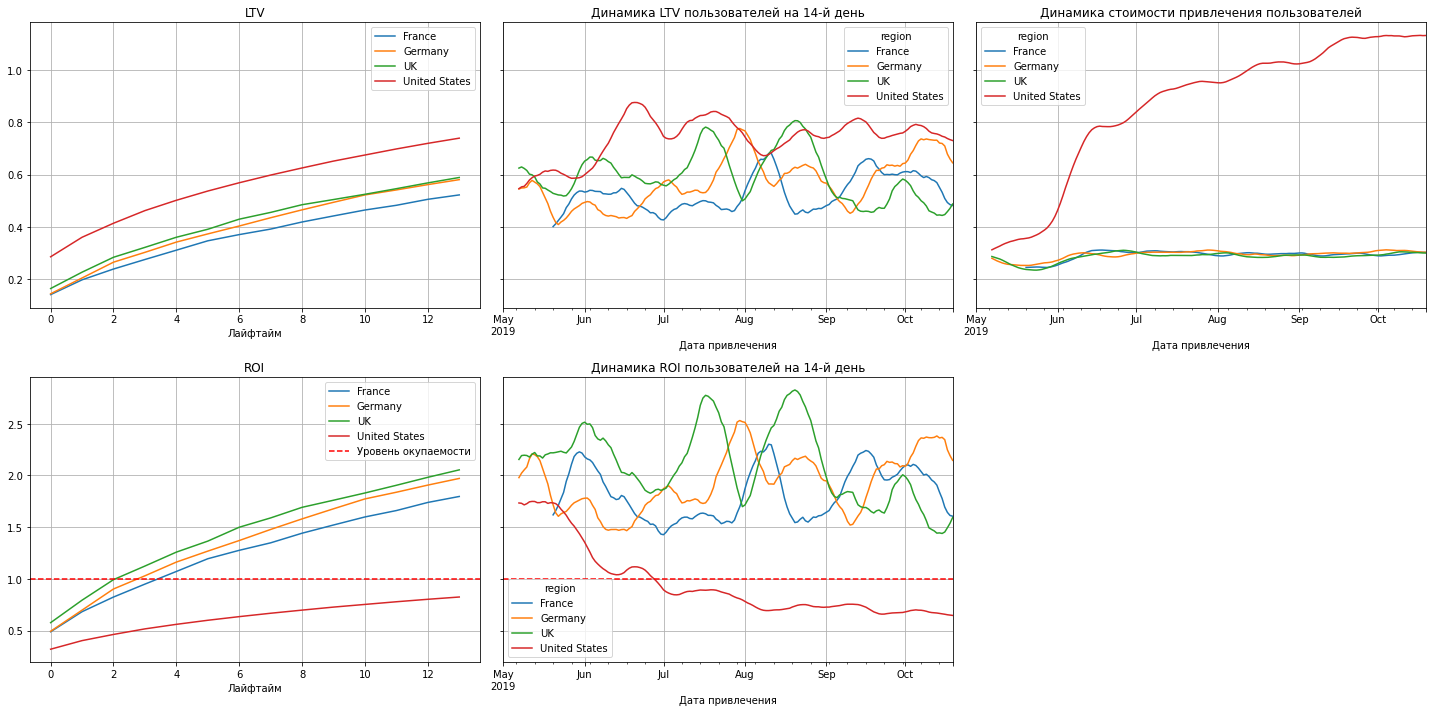

In [32]:
# вызовем функцию расчета и визуализации, с рассмотрением в разрезе каналов привлечения
# передаем функции get_ltv данные по профилям, заказам, дату наблюдений, горизонт
# на выходе получаем данные по LTV, ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days,
                                                                       dimensions=['region'], ignore_horizon=False)
# для данных о динамике LTV и ROI применим функцию сглаживания с периодом 17 дней
ltv_history = filter_data(ltv_history, 14)
roi_history = filter_data(roi_history, 14)

# и с помощью функции визуализации этих показателей посмотрим на них в графиках
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

**Выводы по графикам по странам присутствия**

- пользователи из US больше всего платят в приложении, как видно по графику LTV
- при этом они же единственные не окупают вложения в их привлечение
- потому что расходы на их привлечение самые высокие и постоянно растут, при том что расходы на привлечение в других странах остаются на одном стабильном уровне


Посмотрим на конверсию и удержание пользователей с разбивкой по устройствам, каналам и странам.

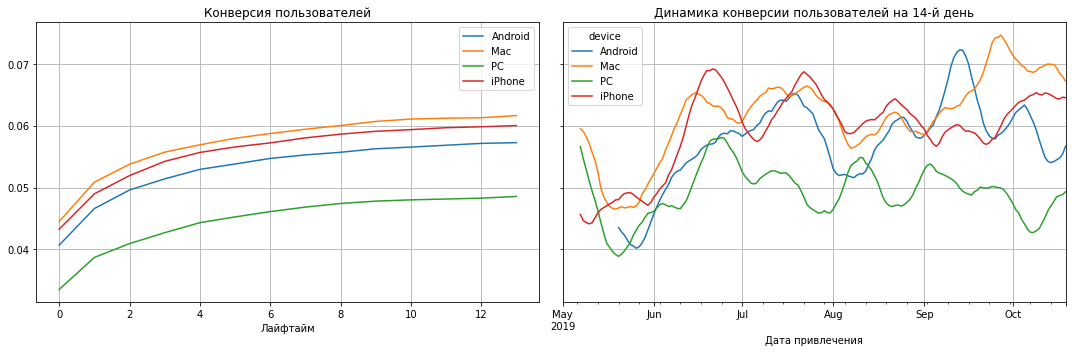

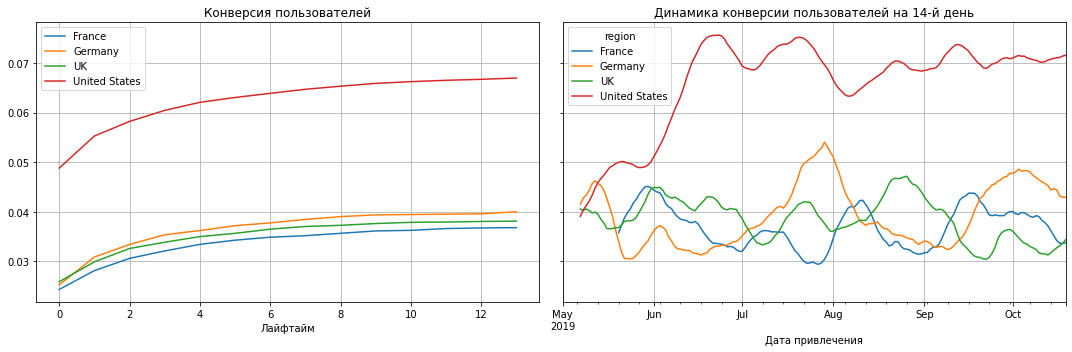

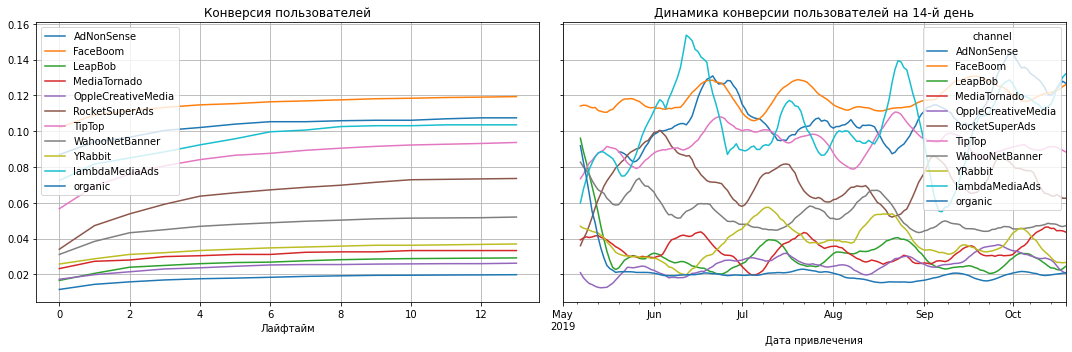

In [33]:
# для этого применим функцию get_conversion
# сделаем это в цикле по требуемой разбивке 
for dim in ['device', 'region', 'channel']:
    conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = [dim], ignore_horizon=False,)
    # применим функцию сглаживания по скользящим средним для динамики
    conversion_history = filter_data(conversion_history, 14)
    # с помощью ранее определенной функции выведем графики
    plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

**Выводы по графикам конверсии**

- самая низкая конверсия у пользователей с персональных компьютеров, и имеет тенденцию к снижению
- самая высокая конверсия у пользователей Mac
- среди стран с большим отрывом по конверсии лидирует США, остальные страны примерно на одном уровне
- по каналам привлечения есть группа лидеров: FaceBoom, AdNonSense, LambdaMediaAds, TipTop

Посмотрим на графики удержания с разбивкой по устройствам, каналам и странам.

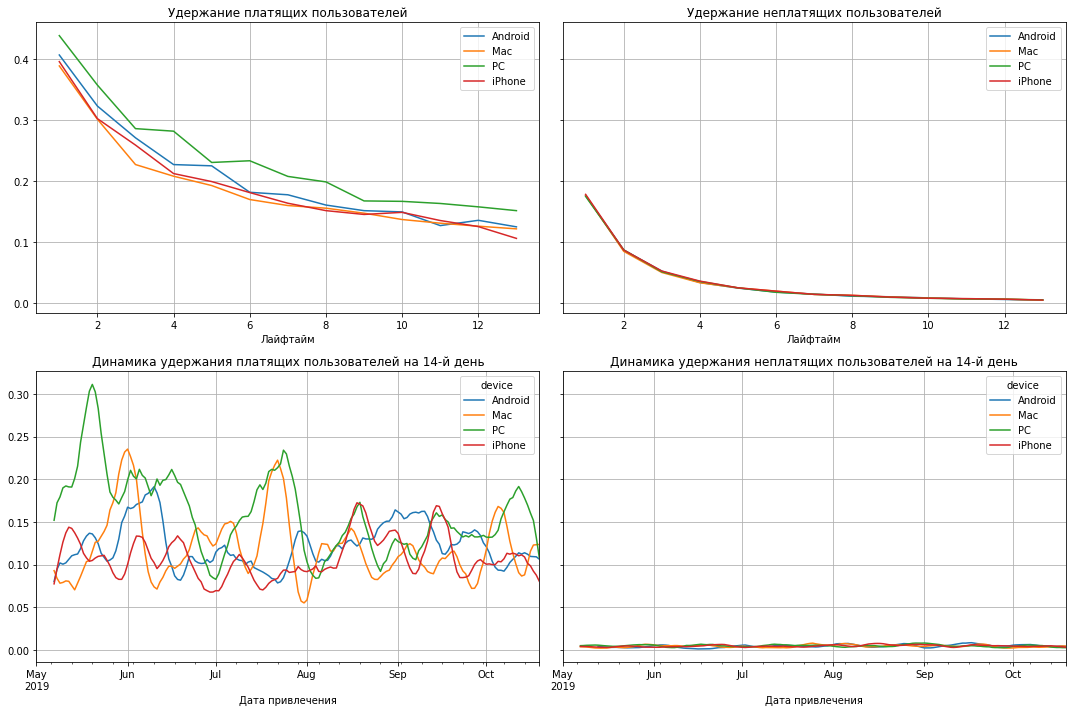

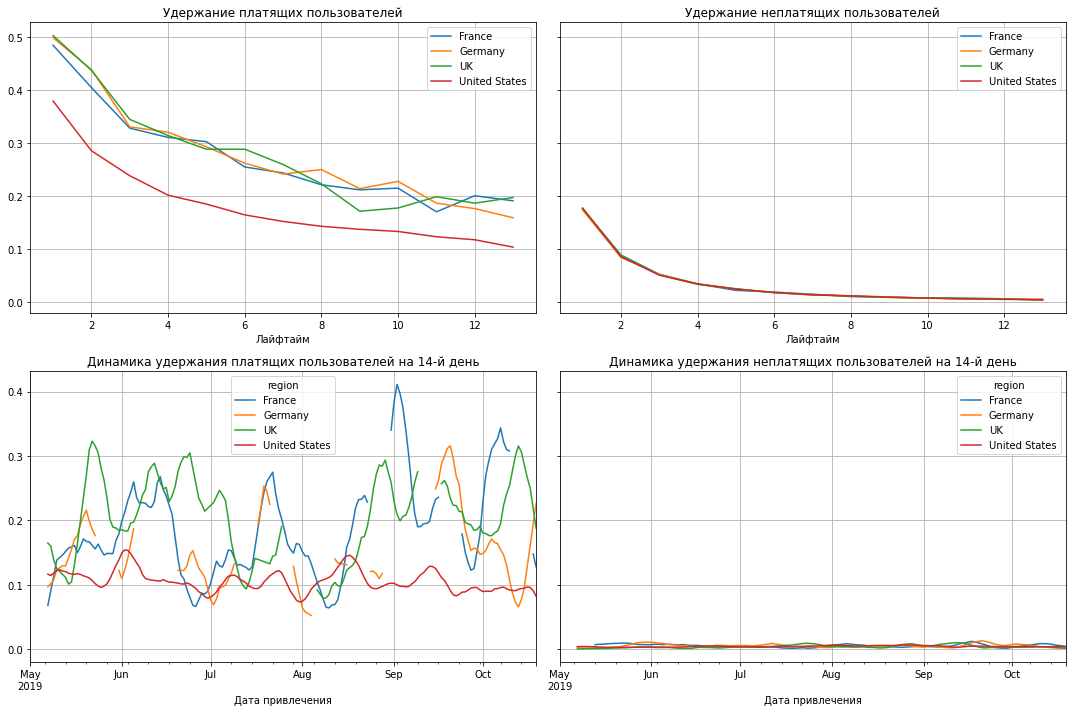

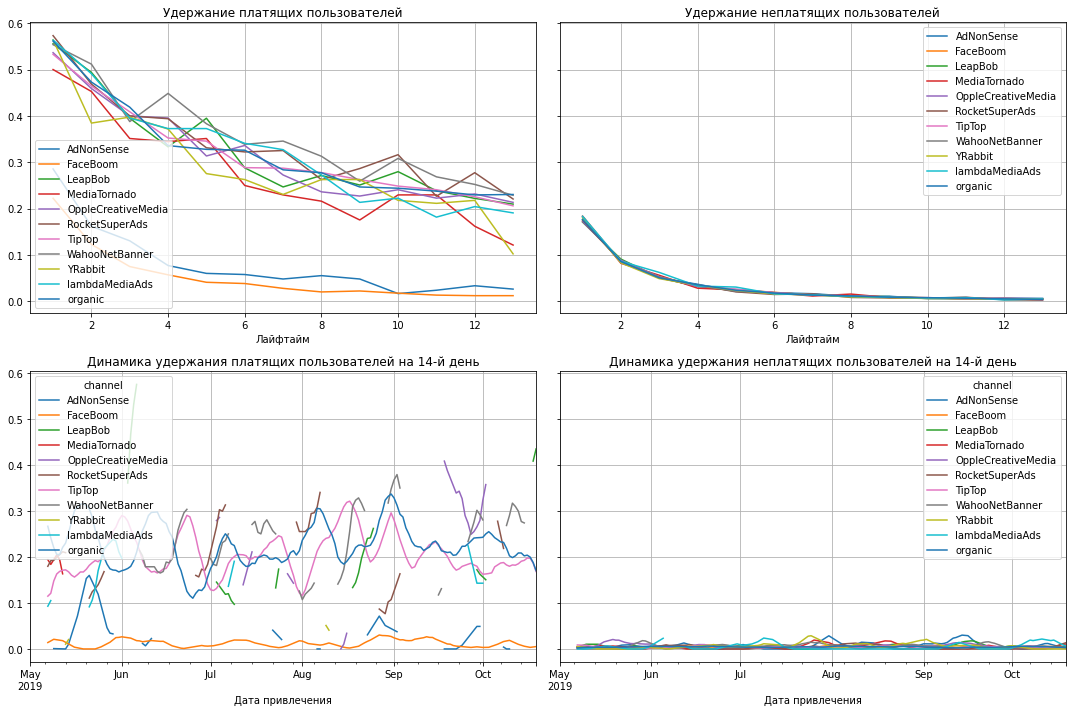

In [34]:
for dim in ['device', 'region', 'channel']:
    retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions=[dim], ignore_horizon=False)
    retention_in_time = filter_data(retention_in_time, 7)
    plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)
    

**Выводы по графикам удержания**

- удержание практически не зависит от платформы, которой пользуется клиент
- удержание клиентов из США значительно ниже, чем из других стран, причем этот невысокий показатель стабилен с течением времени
- среди каналов привлечения значительно ниже показатели удержания у канала FeceBoom, он даже ниже удержания органических пользователей

**Общие выводы по графикам конверсии и удержания**

- пользователи из США показывают самую высокую конверсию, и самое низкое удержание, то есть клиентов привлекают, они совершают покупку, но не возвращаются. Необходимо исследовать причины этого явления
- у пользователей с РС низкая конверсия, но самое высокое удержание
- пользователи, привлеченные через канал FaceBoom показывают самую высокую конверсию, и самое низкое удержание, то есть клиентов привлекают, они совершают покупку, но не возвращаются. Необходимо исследовать причины этого явления. Возможно все клиенты из США привлечены через FaceBoom. Проверим это, и заодно посмотрим на то, где привлекают клиентов через TipTop

In [35]:
fb_data = profiles.groupby(['channel', 'region']).agg({'user_id' :'count', 'payer': 'sum'}).reset_index()
fb_data.query('channel == "FaceBoom" or channel == "TipTop"')

,channel,region,user_id,payer
3,FaceBoom,United States,29144,3557
12,TipTop,United States,19561,1878


Через FeceBoom привлекаются клиенты только в США, а зная, что клиенты, привлеченные по этому каналу имеют низкое удержание, можно сделать вывод, что на рынке США надо подробно анализировать поведение клиентов привлеченных по этому каналу, так как они демонстрируют высокую конверсию, но низкое удержание.

## **Общие выводы исследования** <a id = 'выводы'></a> 

- В рассматриваемом периоде реклама в целом не окупается.
- Начиная с июня наблюдается рост расходов не рекламу
- Этот рост обусловлен ростом расходов на привлечение через канал TipTop, но пользователи привлеченные через этот канал не окупаются за требуемые бизнес-планом срок в 14 дней
- Также не окупаются вложения в каналы FaceBoom и AdNonSense
- Клиенты, привлекаемые в США чаще других становятся плательщиками, но реже других возвращаются в приложение
- У разных каналов привлечения разная сезонность
- Пользователи РС реже других становятся плательщиками, но чаще других пользуются приложением повторно


**Рекомендации для отдела маркетинга:**
- В первую очередь уделить внимание рынку США, на котором высокие расходы на рекламу, которые не окупаются
- При этом пользователи из этой страны чаще других платят, но реже возвращаются в приложение. Возможно на этом рынке была какая-то агрессивная рекламная капмания, которая привлекла много пользователей, но которым фактически приложение не интересно
- Выяснить, почему значительно выросли расходы на рекламу через канал TipTop, возможно отказаться от него как от неокупаемого
- Детально проанализировать поведение клиентов, привлеченных через FaceBoom, почему они часто покупают, но редко возвращаются
- Проверить расходы на рекламу через  AdNonSense, клиенты приведенные через этот канал также не окупаются
- Посмотреть на сезонность каналов, и использовать ее при планировании дальнейших рекламных акций